# Explainable and Responsible AI Toolkit (v2.0 - 2023-05)
***Developed by AI COE and DS Consulting***

The **DSAI Explainable and Responsible AI (XRAI) Toolkit** is a complementary tool to the [XRAI Guidelines document](https://unionbankphilippines.sharepoint.com/:w:/r/sites/DataScienceInsightsTeam/_layouts/15/Doc.aspx?sourcedoc=%7B6052036E-D049-4EE3-BCED-D4B9B5C65FEA%7D&file=XRAI%20Guidelines%20Document_working%20file.docx&action=default&mobileredirect=true) **(NOT THE FINAL FILE YET)**. The Toolkit provides a one-stop tool for technical tests were identified by packaging widely used open-source libraries into a single platform, according to ADI/DSAI user needs. These tools include Python libraries such as `dice-ml`, `econml`, `interpret-community`, `erroranalysis`, `scikit-learn`, and UI visualization libraries such as `raiwidgets`. This toolkit aims to: 
- Provide a user interface to guide users step-by-step in the testing process; 
- Support certain binary classification and regression models that use tabular data 
- Produce a basic summary report to help DSAI System Developers and Owners interpret test results 
- Intended to be deployable in the user’s environment

This Toolkit, along with the Guidelines document, is the first major version release. Subsequent versions and updates will be found in the XRAI GitHub repo **(LINK PENDING)**, accompanied by quarterly XRAI Brownbag sessions.

# Introduction
## Assumptions / Limitations
The toolkit is in its second iterations of development. As such, there are limitations which hinders the Toolkit from being able to handle certain models and display other XRAI-related features. These include:
- V2 can only handle binary classification models and regression models 
- Only Python users for V2. An R-based Toolkit may be released according to demand and necessity for later versions 
- Certain features may be discussed in Guidelines V2 but are not yet in Toolkit V2 
- This notebook does not define ethical standards. It provides a way for DSAI System Developers and Owners to demonstrate their claims about the performance of their DSAI systems according to the XRAI principles
- `fairness.py` and `XRAI_features.py` are the source function codes containing all functions and will be updated in each release
- Protected groups are those groups you want to compare model performance on them to all data they can be defined as this format `{"feature name 1":  value, "feature name 2":  value,...}`  you can define as many protected groups as you want, and they can be numerical or even categorical, such as `{age: 23, sex: "female"}`.
- UI is available on local machine for now


## Inputs
Our interactive toolkit only needs two main inputs before any major analysis:
- Model (.pkl or .sav)
- Data (train, test) (.csv) 

We intend for the user to have inputs mostly on the XRAI-related functions. However, we need the user to manually input **the names of train and test file**, in addition to target variable name. Prompts will be shown later in the notebook where you will need to load. In the shared folder we have provided sample model and data (test_data.csv, train_data.csv, finalized_model.pkl). For testing for different models and data you may just replace files.

## Features found in the notebook
- Fairness 
- Model performance overview
- DICE & QII and Dalex
- Stability


## Features found in the Interactive UI
1. Error analysis 
2. Model overview (evaluation matrices on whole test data as well as single data point)
3. Data Analysis (statistics of predicted outcome, dataset features and error groups)
4. Feature importance (See how each feature is important for Individual data point and whole data seperately)
5. What-if analysis (observe how the model's prediction changes: Change features manually or specify the desired prediction 

# File and model selection
Ingest the test and train csv files, target features, and model. 

In [1]:
# Call functions
%matplotlib inline
import pandas as pd

# load model and data
from data_model import load_data_model

#Performance overview 
from fairness import model_performance

# Fairness
from fairness import fairness

# Local explanation
from local_exp import dice_exp, exp_cf
from local_exp import dalex_exp, break_down, interactive
from local_exp import Predictor, exp_qii, get_feature_names, profiles

# Global explanation
import shap
shap.initjs() # print the JS visualization code to the notebook

# Stability
from stability import psi_list
from stability import PageHinkley
from stability import ks

# Display
from IPython.display import HTML, display
from sklearn import set_config
set_config(display = 'diagram')

import os
os.getcwd()

'/home/cdsw/XRAI_V2_20230102'

In [2]:
# load required datasets and model
train_data = '/home/cdsw/data/ipvs/00_orig_train_IPVS_for_XRAI_2023-02-17.csv' ## INPUT HERE
test_data = '/home/cdsw/data/ipvs/00_orig_test_IPVS_for_XRAI_2023-02-17.csv' ## INPUT HERE
model_path = {"Xgboost":'/home/cdsw/models/ipvs/xgboost_2023-03-02.sav',"DT":'/home/cdsw/models/ipvs/decision_tree_2023-03-02.sav'} ## INPUT HERE
target_feature = 'price_sqm' ## INPUT HERE

X_train, Y_train, X_test, Y_test, train_data, test_data, model = load_data_model(train_data, test_data, model_path, target_feature)

# Performance and Fairness

***More info about metrics of classification***

 **For classification;**
 Metrics are Disparity impact (DI), Equal opportunity (EOP), Equalized odds (EOD), It provides other indexes like `Accuracy`,`True_positive_rate`, `False_positive_rate`, `False_negative_rate`, `predicted_as_positive`, `Recall`, `Precision`, `F1 score` and `AUC`  of overall data and defined groups in a table for comparison. 
 
#### Equal opportunity (EOP)
Under equal opportunity we consider a model to be fair if the TPRs of the privileged and unprivileged groups are equal. 
In practice, we will give some leeway for statistic uncertainty. 
We can require the differences to be less than a certain cutoff.

#### Equalized odds
This can be interpreted as the percentage of people who have wrongfully benefited from the model.

#### Disparity Index
 That is the predicted as positive for the normal group must not be less than cutoff of that of the protected group

#### Cutoff
The question is what cutoff should we use? There is actually no good answer to that. It will depend on your industry and application. If your model has significant consequences, like for mortgage applications, you will need a stricter cutoff. The cutoff may even be defined by law. Either way, it is important to define the cutoffs before you measure fairness.
 0.8 seems to be a good defualt value for that. 

 **Regression;**
 Having Explainers, we are able to assess models' fairness. To make sure that the models are fair, we will be checking three independence criteria. These are:

independence: R⊥A
separation: R⊥A ∣ Y
sufficiency: Y⊥A ∣ R
Where:

A - protected group
Y - target
R - model's prediction
In the approach described in Steinberg, D., et al. (2020), the authors propose a way of checking this independence.
***More info about metrics of regression***
https://arxiv.org/pdf/2001.06089.pdf

 ## Fairness
 `fairness()` function takes the model, data,  protected groups and fairness metric and treshold as an input as an input, calculates that eighter model is fair to the defined protected groups or not. 
 
 

In [3]:
fairness(model, X_test, Y_test, {"LGU" : 'pasay','income_class':"1st" }, metric="DI", threshold=0.8,reg=True,xextra=False)

-------------------Model : Xgboost---- Protected group: LGU--------------------------
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           independence  separation  sufficiency
subgroup                                        
LGU_pasay      1.092552    1.036471     1.174789
-------------------Model : DT---- Protected group: LGU--------------------------
Bias detected in 1 metrics: independence

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           independence  separation  sufficiency
subgroup                                        
LGU_pasay      1.307286    1.155072     1.180181


-------------------Model : Xgboost---- Protected group: income_class--------------------------
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                  independence  separation  sufficiency
subgroup                                               
income_class_1st      1.003804     1.00015     1.004078
-------------------Model : DT---- Protected group: income_class--------------------------
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, based on 'else'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                  independence  separation  sufficiency
subgroup                                               
income_class_1st      1.003234    1.000029     1.004559


In some cases there might be features that are not considered in the model, but we need to evaluate fairness and performance of model on them also. The possibility of adding the extra features to the evaluations is provided here. See the example below.   

In [4]:
# Example of having variables outside of model to calculate fairness
xextra = X_test[['ac_unit','balcony']]
xextra.columns = ["ac_unit_2","balcony_2"]
#xextra

## Performance
`model_performance()`  gives an overview on model performance on test and train datasets also calculate performance for the protected group(s) vs all other data points.

In [5]:
model_performance(model['Xgboost'], X_test, Y_test, X_train, Y_train, test_data, train_data, target_feature, protected_groups={"garage" : 0,'income_class':"1st" }, reg=True)

Overal performence for Train data is :


Split protected_groups  Mean Absolute Percentage Error  \
0  Overall performance                -                    2.441765e-03   
1                    1           garage                    2.522302e-03   
2                    2           garage                    1.233797e-07   
1                  1st     income_class                    3.307815e-03   
2              Special     income_class                    6.907124e-04   

   Mean Absolute Error        R2     Max Error  
0           866.163839  0.998662  1.623377e+06  
1           894.733438  0.998650  1.623377e+06  
2             0.021028  1.000000  1.246753e+00  
1          1227.698652  0.998423  1.623377e+06  
2           135.182958  0.999976  7.090909e+04

Overal performence for Test data is :


Split protected_groups  Mean Absolute Percentage Error  \
0  Overall performance                -                        0.554405   
1                    1           garage                        0.557573   
2                    2           garage                        0.444070   
1                  1st     income_class                        0.522138   
2              Special     income_class                        0.619688   

   Mean Absolute Error        R2     Max Error  
0        149485.588833  0.706974  4.784759e+06  
1        149552.316260  0.710425  4.784759e+06  
2        147161.806180  0.381303  1.778168e+06  
1        160544.995172  0.748683  4.664463e+06  
2        127110.123266  0.325500  4.784759e+06

# Explanation methods - Local

In [6]:
idx = 8
idx

8

## DiCE

Diverse Counterfactual Explanations (DiCE) is a tool developed by Microsoft that provides counterfactual explanations for machine learning models. Counterfactual explanations are a type of explanation that can help users understand why a machine learning model made a particular prediction or decision. They do this by showing what changes would need to be made to the input features of a model in order to change its output.

DiCE is designed to address a common problem with counterfactual explanations: they can often provide only a single, arbitrary solution for how to change the input features. This can be limiting, as it may not give the user a full understanding of how the model is working, or how changes to the input features would impact the output.


To overcome this limitation, DiCE generates multiple counterfactual explanations that are diverse and meaningful. Specifically, DiCE generates a set of counterfactual explanations that satisfy two criteria:
- Relevance: Each counterfactual explanation should be as close as possible to the original input while still changing the model's output. In other words, the changes made to the input should be minimal, to avoid making changes that would not be realistic or practical.
- Diversity: Each counterfactual explanation should be different from the others in the set, in order to provide a range of possible explanations for the model's output.

DiCE uses an optimization algorithm to generate these counterfactual explanations. The algorithm searches for the smallest possible change to the input features that would change the model's output, subject to the constraint that each counterfactual explanation should be diverse from the others in the set.

In [7]:
exp1 = dice_exp(X_train, Y_train, model["Xgboost"], target = target_feature)

X = X_test[1:2]
X

LGU  infrastructure  resiliency  productivity  security  \
1  paranaque            27.0        11.0         861.0     446.0   

   transparency  utilities  ac_unit  balcony  deck  fence  fireplace  ...  \
1           3.0      369.0        0        1     0      1          0  ...   

   fire_station_5000  government_5000  poverty_inc  subs_inc  lgu_type  \
1                  0                7          0.6       0.1      City   

   income_class  anreg_income_2021    capex_2021    socex_2021  pop_2022  \
1           1st       6.933126e+09  2.170734e+09  2.893083e+09    700923   

   growth_5years  growth_10years  
1       2.389393        0.752967  

[1 rows x 122 columns]

In [8]:
e2 = exp_cf(X = X, exp = exp1, total_CFs = 2, features_to_vary = ['balcony', 'LGU'])

  0%|          | 0/1 [00:00<?, ?it/s]

No counterfactuals found for any of the query points! Kindly check your configuration.


## QII

For QII (Quantitative Input Influence):
Quantitative Input Influence (QII) is a method for quantifying the impact of each input feature on the model's output. QII can be used to identify which input features are most important to the model's decision, and how changes to those features would impact the output.

QII works by computing the partial derivatives of the model's output with respect to each input feature. These derivatives indicate how sensitive the model's output is to changes in each feature. By computing the absolute values of these derivatives, QII can rank the input features in order of importance, from most to least influential.

Once the input features have been ranked, QII can be used to generate counterfactual explanations that show how changes to specific input features would impact the model's output. These counterfactual explanations can be used to understand the logic behind the model's decision, and to identify potential biases or errors in the model.

For example, if a model is being used to predict loan approvals, QII could be used to identify which input features are most important to the model's decision, such as income, credit score, and employment history. By generating counterfactual explanations that show how changes to these features would impact the model's output, users can better understand how the model is making its decisions, and identify potential biases or errors in the model. 

More info in https://www.andrew.cmu.edu/user/danupam/datta-sen-zick-oakland16.pdf

In [9]:
model['DT']

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('dropcols', 'drop', []),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No '
                                                                                            'Data',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LGU', 'income_class',
                                                   'lgu_type',
                                                   'price_conditions']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   Standar...
                                                   'fast_food_1000',
                                                   'bank_1000', 'bedrooms',
                                                   'pharmacy_5000',
                                                   'parking_5000',
                                                   'local_parking',
                                                   'poverty_inc',
                                                   'pharmacy_3000',
                                                   'fire_station_5000',
                                                   'library_books',
                                                   'college_5000',
                                                   'residential_5000',
                                                   'townhall_1000', 'cafe_1000', ...])])),
                ('feature_selection', VarianceThreshold(threshold=0.05)),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=20,
                                       random_state=42))])

In [10]:
from sklearn.pipeline import Pipeline

# Put all preprocessing steps into one object
pipe = Pipeline(
    steps = [
        ('step1', model['DT'][0]),
        ('step2', model['DT'][1])
    ]
)

pipe.fit(X_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(transformers=[('dropcols', 'drop', []),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No '
                                                                                            'Data',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LGU', 'income_class',
                                                   'lgu_type',
                                                   'price_conditions']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardS...
                                                   'restaurant_3000',
                                                   'floor_area',
                                                   'industrial_1000',
                                                   'restaurant_5000',
                                                   'supermarket_3000',
                                                   'fast_food_1000',
                                                   'bank_1000', 'bedrooms',
                                                   'pharmacy_5000',
                                                   'parking_5000',
                                                   'local_parking',
                                                   'poverty_inc',
                                                   'pharmacy_3000',
                                                   'fire_station_5000',
                                                   'library_books',
                                                   'college_5000',
                                                   'residential_5000',
                                                   'townhall_1000', 'cafe_1000', ...])])),
                ('step2', VarianceThreshold(threshold=0.05))])

In [11]:
pipe.transform(X_test).shape

(2866, 127)

This takes quite a while!

QII with banzhaf method:
Percent: [####################] 100% Count: 600 Approx: 172.59 | Done...
banzhaf: 
{0: 0.0, 1: 0.0012816934170737369, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: -0.0004681321237497093, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.11932484298674105, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 2.5587345894394047e-05, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.047159223075133705, 23: 9.362642474994184e-05, 24: 0.0, 25: 0.0, 26: -0.00026168876482902996, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 6.571295650151203e-05, 32: 0.0, 33: 0.012741335194231195, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: -0.00026168876482902996, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.008389741800418684, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 6.513142591300296e-05, 54: 0.0, 55: 0.0, 56: 0.0, 57: -0.0004681321237497093, 58: 0.0, 59: 0.020034310304722035, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.012446499185857158, 65: 0.0, 66: 0.00023203070481507326, 67: 0.0, 

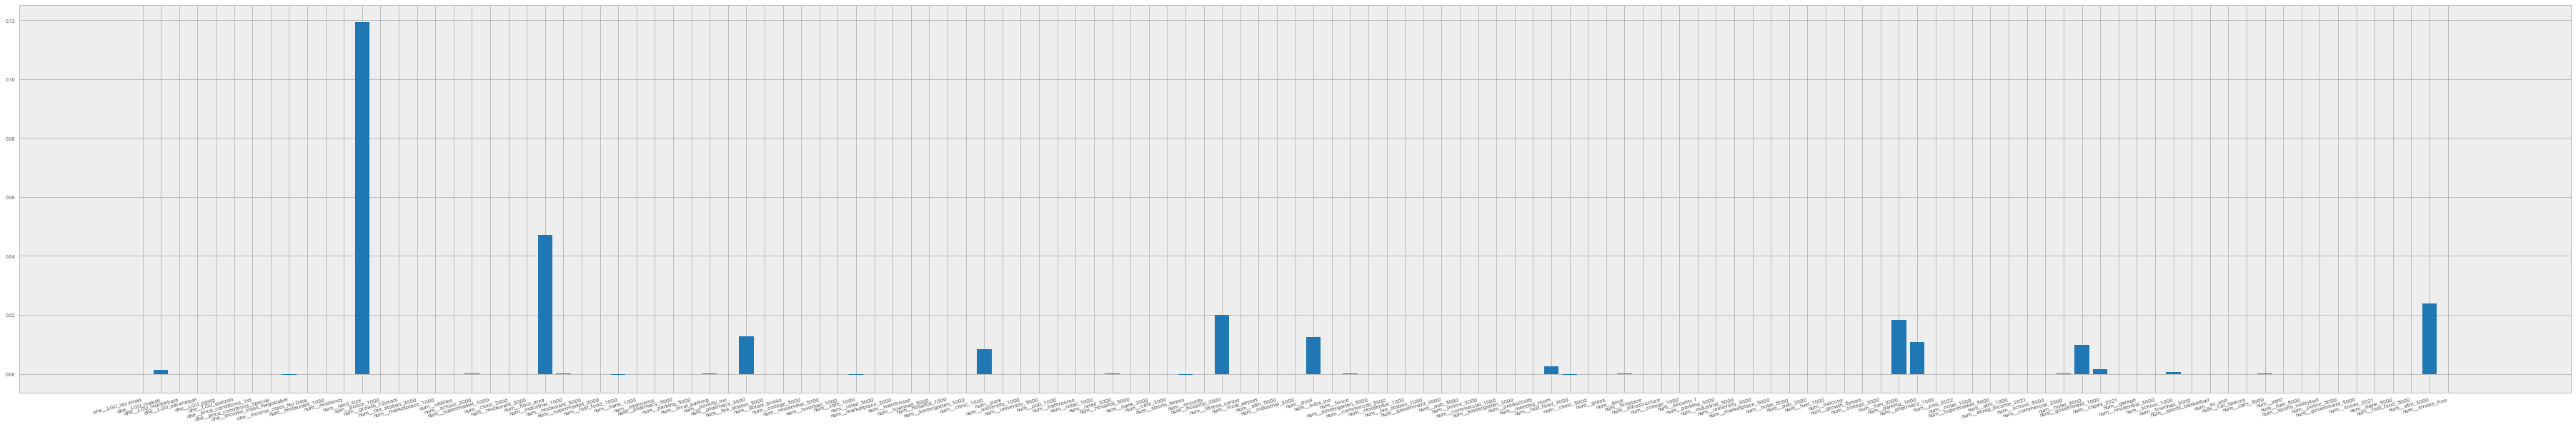

columns    values
0     ohe__LGU_las pinas  0.000000
1        ohe__LGU_makati  0.001282
2    ohe__LGU_muntinlupa  0.000000
3     ohe__LGU_paranaque  0.000000
4         ohe__LGU_pasig  0.000000
..                   ...       ...
122      num__socex_2021  0.000000
123       num__bank_5000  0.000000
124  num__fast_food_5000  0.000000
125        num__atm_3000  0.023844
126      num__smoke_free  0.000000

[127 rows x 2 columns]

In [12]:
cont = X_train.select_dtypes(include = ['int64', 'float64']).columns.tolist()
cat = X_train.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

# Takes long!
qii_df = exp_qii(model['DT'][-1], pipe, X_test, idx, cat, method = 'banzhaf')
qii_df

## Dalex

Prepare model explainer: This function creates model adapters: objects with standardized structures that are used by other methods in the package for model exploration and explanations.

**Break Down**: How can your model response be explained by the model's features? What are the most important features of the model? This function is best for why questions, or when you have a moderate number of features. Just be careful when features are correlated.

In [13]:
exp, obs = dalex_exp(model["DT"], X_train, Y_train, X_test, idx)
break_down(exp, obs)

Preparation of a new explainer is initiated

  -> data              : 11462 rows 122 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 11462 values
  -> model_class       : sklearn.tree._classes.DecisionTreeRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fbca896fea0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 2.05e+03, mean = 3.49e+05, max = 9.62e+06
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.62e+06, mean = 5.02e+03, max = 6.32e+06
  -> model_info        : package sklearn

A new explainer has been created!


variable_name variable_value                 variable     cumulative  \
0           intercept              1                intercept  348640.556567   
1    marketplace_5000           32.0  marketplace_5000 = 32.0  390251.198896   
2            atm_3000           17.0          atm_3000 = 17.0  405067.897162   
3           land_size          120.0        land_size = 120.0  384645.687423   
4                yard            4.0               yard = 4.0  392008.056238   
..                ...            ...                      ...            ...   
119       school_5000          172.0      school_5000 = 172.0  392581.537476   
120        hotel_5000           11.0        hotel_5000 = 11.0  392581.537476   
121       school_1000            9.0        school_1000 = 9.0  432797.436611   
122               LGU      paranaque          LGU = paranaque  104166.666667   
123                                                prediction  104166.666667   

      contribution  sign  position                  label  
0    348640.556567   1.0       123  DecisionTreeRegressor  
1     41610.642329   1.0       122  DecisionTreeRegressor  
2     14816.698266   1.0       121  DecisionTreeRegressor  
3    -20422.209739  -1.0       120  DecisionTreeRegressor  
4      7362.368815   1.0       119  DecisionTreeRegressor  
..             ...   ...       ...                    ...  
119       0.000000   0.0         4  DecisionTreeRegressor  
120       0.000000   0.0         3  DecisionTreeRegressor  
121   40215.899135   1.0         2  DecisionTreeRegressor  
122 -328630.769944  -1.0         1  DecisionTreeRegressor  
123  104166.666667   1.0         0  DecisionTreeRegressor  

[124 rows x 8 columns]

variable_name variable_value                 variable     cumulative  \
0           intercept              1                intercept  348640.556567   
1    marketplace_5000           32.0  marketplace_5000 = 32.0  390251.198896   
2            atm_3000           17.0          atm_3000 = 17.0  405067.897162   
3           land_size          120.0        land_size = 120.0  384645.687423   
4                yard            4.0               yard = 4.0  392008.056238   
..                ...            ...                      ...            ...   
119       school_5000          172.0      school_5000 = 172.0  392581.537476   
120        hotel_5000           11.0        hotel_5000 = 11.0  392581.537476   
121       school_1000            9.0        school_1000 = 9.0  432797.436611   
122               LGU      paranaque          LGU = paranaque  104166.666667   
123                                                prediction  104166.666667   

      contribution  sign  position                  label  
0    348640.556567   1.0       123  DecisionTreeRegressor  
1     41610.642329   1.0       122  DecisionTreeRegressor  
2     14816.698266   1.0       121  DecisionTreeRegressor  
3    -20422.209739  -1.0       120  DecisionTreeRegressor  
4      7362.368815   1.0       119  DecisionTreeRegressor  
..             ...   ...       ...                    ...  
119       0.000000   0.0         4  DecisionTreeRegressor  
120       0.000000   0.0         3  DecisionTreeRegressor  
121   40215.899135   1.0         2  DecisionTreeRegressor  
122 -328630.769944  -1.0         1  DecisionTreeRegressor  
123  104166.666667   1.0         0  DecisionTreeRegressor  

[124 rows x 8 columns]

**Interactions**: The effects of an explanatory variable depends on the values of other variables. How does that affect the model response? We focus on pairwise interactions.

This may take a while depending on the model and number of variables you have.

In [14]:
# Interactive
interactive(exp, obs, count = 10)

variable_name variable_value  \
0                          intercept              1   
1              retail_1000:land_size      2.0:120.0   
2   marketplace_5000:industrial_1000       32.0:0.0   
3             hotel_5000:school_5000     11.0:172.0   
4          residential_5000:atm_3000     285.0:17.0   
..                               ...            ...   
76                 fire_station_5000            0.0   
77                      transparency            3.0   
78                 fire_station_1000            0.0   
79                          lgu_type           City   
80                                                    

                                       variable     cumulative   contribution  \
0                                     intercept  348640.556567  348640.556567   
1             retail_1000:land_size = 2.0:120.0  433813.253533   85172.696966   
2   marketplace_5000:industrial_1000 = 32.0:0.0  440984.385538    7171.132005   
3           hotel_5000:school_5000 = 11.0:172.0  456189.557410   15205.171872   
4        residential_5000:atm_3000 = 285.0:17.0  471381.881252   15192.323842   
..                                          ...            ...            ...   
76                      fire_station_5000 = 0.0  104166.666667       0.000000   
77                           transparency = 3.0  104166.666667       0.000000   
78                      fire_station_1000 = 0.0  104166.666667       0.000000   
79                              lgu_type = City  104166.666667       0.000000   
80                                   prediction  104166.666667  104166.666667   

    sign  position                  label  
0    1.0        80  DecisionTreeRegressor  
1    1.0        79  DecisionTreeRegressor  
2    1.0        78  DecisionTreeRegressor  
3    1.0        77  DecisionTreeRegressor  
4    1.0        76  DecisionTreeRegressor  
..   ...       ...                    ...  
76   0.0         4  DecisionTreeRegressor  
77   0.0         3  DecisionTreeRegressor  
78   0.0         2  DecisionTreeRegressor  
79   0.0         1  DecisionTreeRegressor  
80   1.0         0  DecisionTreeRegressor  

[81 rows x 8 columns]

variable_name variable_value  \
0                          intercept              1   
1              retail_1000:land_size      2.0:120.0   
2   marketplace_5000:industrial_1000       32.0:0.0   
3             hotel_5000:school_5000     11.0:172.0   
4          residential_5000:atm_3000     285.0:17.0   
..                               ...            ...   
76                 fire_station_5000            0.0   
77                      transparency            3.0   
78                 fire_station_1000            0.0   
79                          lgu_type           City   
80                                                    

                                       variable     cumulative   contribution  \
0                                     intercept  348640.556567  348640.556567   
1             retail_1000:land_size = 2.0:120.0  433813.253533   85172.696966   
2   marketplace_5000:industrial_1000 = 32.0:0.0  440984.385538    7171.132005   
3           hotel_5000:school_5000 = 11.0:172.0  456189.557410   15205.171872   
4        residential_5000:atm_3000 = 285.0:17.0  471381.881252   15192.323842   
..                                          ...            ...            ...   
76                      fire_station_5000 = 0.0  104166.666667       0.000000   
77                           transparency = 3.0  104166.666667       0.000000   
78                      fire_station_1000 = 0.0  104166.666667       0.000000   
79                              lgu_type = City  104166.666667       0.000000   
80                                   prediction  104166.666667  104166.666667   

    sign  position                  label  
0    1.0        80  DecisionTreeRegressor  
1    1.0        79  DecisionTreeRegressor  
2    1.0        78  DecisionTreeRegressor  
3    1.0        77  DecisionTreeRegressor  
4    1.0        76  DecisionTreeRegressor  
..   ...       ...                    ...  
76   0.0         4  DecisionTreeRegressor  
77   0.0         3  DecisionTreeRegressor  
78   0.0         2  DecisionTreeRegressor  
79   0.0         1  DecisionTreeRegressor  
80   1.0         0  DecisionTreeRegressor  

[81 rows x 8 columns]

**Additive**: How does the average model response change when new features are being fixed in the observation of interest? What if we force a specific order of variables?

In [15]:
# Additive
order = ['LGU', 'security', 'park', 'local_parking', 'smoke_free', 'yard']

break_down(exp, obs, order)

variable_name variable_value             variable     cumulative  \
0      intercept              1            intercept  348640.556567   
1            LGU      paranaque      LGU = paranaque  263079.735542   
2       security          446.0     security = 446.0  261584.046934   
3           park            1.0           park = 1.0  262938.912943   
4  local_parking            3.0  local_parking = 3.0  264726.581355   
5     smoke_free            0.0     smoke_free = 0.0  265016.231555   
6           yard            4.0           yard = 4.0  277709.161000   
7                                         prediction  104166.666667   

    contribution  sign  position                  label  
0  348640.556567   1.0         7  DecisionTreeRegressor  
1  -85560.821025  -1.0         6  DecisionTreeRegressor  
2   -1495.688608  -1.0         5  DecisionTreeRegressor  
3    1354.866009   1.0         4  DecisionTreeRegressor  
4    1787.668412   1.0         3  DecisionTreeRegressor  
5     289.650200   1.0         2  DecisionTreeRegressor  
6   12692.929445   1.0         1  DecisionTreeRegressor  
7  104166.666667   1.0         0  DecisionTreeRegressor

variable_name variable_value             variable     cumulative  \
0      intercept              1            intercept  348640.556567   
1            LGU      paranaque      LGU = paranaque  263079.735542   
2       security          446.0     security = 446.0  261584.046934   
3           park            1.0           park = 1.0  262938.912943   
4  local_parking            3.0  local_parking = 3.0  264726.581355   
5     smoke_free            0.0     smoke_free = 0.0  265016.231555   
6           yard            4.0           yard = 4.0  277709.161000   
7                                         prediction  104166.666667   

    contribution  sign  position                  label  
0  348640.556567   1.0         7  DecisionTreeRegressor  
1  -85560.821025  -1.0         6  DecisionTreeRegressor  
2   -1495.688608  -1.0         5  DecisionTreeRegressor  
3    1354.866009   1.0         4  DecisionTreeRegressor  
4    1787.668412   1.0         3  DecisionTreeRegressor  
5     289.650200   1.0         2  DecisionTreeRegressor  
6   12692.929445   1.0         1  DecisionTreeRegressor  
7  104166.666667   1.0         0  DecisionTreeRegressor

**Ceteris Paribus**: How would the model response change for a particular observation if only a single feature is changed? This function is best for what if questions. Just be careful when features are correlated.

In [16]:
# Ceteris Paribus
prof_vars = ['land_size', 'bathrooms', 'growth_5years'] # numerical variables only
profiles(exp, obs, prof_vars, cont)

Calculating ceteris paribus: 100%|██████████| 122/122 [00:01<00:00, 107.80it/s]


LGU  infrastructure  resiliency  productivity  security  \
8     paranaque            27.0        11.0         861.0     446.0   
8        makati            27.0        11.0         861.0     446.0   
8        quezon            27.0        11.0         861.0     446.0   
8   mandaluyong            27.0        11.0         861.0     446.0   
8         pasig            27.0        11.0         861.0     446.0   
..          ...             ...         ...           ...       ...   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   

    transparency  utilities  ac_unit  balcony  deck  fence  fireplace  ...  \
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
..           ...        ...      ...      ...   ...    ...        ...  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   

    income_class  anreg_income_2021    capex_2021    socex_2021  pop_2022  \
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
..           ...                ...           ...           ...       ...   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   

    growth_5years  growth_10years  _original_        _yhat_         _vname_  \
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  5.627284e+06             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
..            ...             ...         ...           ...             ...   
8        2.389393        1.992545    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.011521    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.030496    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.049471    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.068446    0.752967  1.041667e+05  growth_10years   

    _ids_                _label_  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
..    ...                    ...  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor 

LGU  infrastructure  resiliency  productivity  security  \
8     paranaque            27.0        11.0         861.0     446.0   
8        makati            27.0        11.0         861.0     446.0   
8        quezon            27.0        11.0         861.0     446.0   
8   mandaluyong            27.0        11.0         861.0     446.0   
8         pasig            27.0        11.0         861.0     446.0   
..          ...             ...         ...           ...       ...   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   
8     paranaque            27.0        11.0         861.0     446.0   

    transparency  utilities  ac_unit  balcony  deck  fence  fireplace  ...  \
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
..           ...        ...      ...      ...   ...    ...        ...  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   
8              3      369.0      2.0      1.0   0.0    1.0        1.0  ...   

    income_class  anreg_income_2021    capex_2021    socex_2021  pop_2022  \
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
..           ...                ...           ...           ...       ...   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   
8            1st       6.933126e+09  2.170734e+09  2.893083e+09  700923.0   

    growth_5years  growth_10years  _original_        _yhat_         _vname_  \
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  5.627284e+06             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
8        2.389393        0.752967   paranaque  1.041667e+05             LGU   
..            ...             ...         ...           ...             ...   
8        2.389393        1.992545    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.011521    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.030496    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.049471    0.752967  1.041667e+05  growth_10years   
8        2.389393        2.068446    0.752967  1.041667e+05  growth_10years   

    _ids_                _label_  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
..    ...                    ...  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor  
8       8  DecisionTreeRegressor 

## SHAP

In [17]:
X_train_proc = pipe.transform(X_train)
X_train_proc

array([[ 0.        ,  0.        ,  0.        , ..., -0.52866006,
        -0.60496726, -0.31639465],
       [ 0.        ,  0.        ,  0.        , ..., -0.65027798,
        -0.60496726, -0.31639465],
       [ 0.        ,  0.        ,  0.        , ..., -0.65027798,
        -0.60496726, -0.31639465],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.09731449,
        -0.03940199, -0.31639465],
       [ 0.        ,  0.        ,  0.        , ...,  0.45859123,
         1.22224362, -0.31639465],
       [ 0.        ,  0.        ,  0.        , ...,  0.46574523,
         2.35337416, -0.31639465]])

In [18]:
try:
    feature_names = get_feature_names(pipe, cat)
except:
    p_ind = pipe[-1].get_support(indices = True)
    fn = get_feature_names(pipe[0], cat)
    feature_names = [fn[x] for x in p_ind]
        
feature_names

['ohe__LGU_las pinas',
 'ohe__LGU_makati',
 'ohe__LGU_muntinlupa',
 'ohe__LGU_paranaque',
 'ohe__LGU_pasig',
 'ohe__LGU_quezon',
 'ohe__price_conditions_1st',
 'ohe__price_conditions_Special',
 'ohe__income_class_Negotiable',
 'ohe__income_class_No Data',
 'num__restaurant_1000',
 'num__resiliency',
 'num__land_size',
 'num__police_1000',
 'num__growth_10years',
 'num__fire_station_3000',
 'num__marketplace_1000',
 'num__utilities',
 'num__school_3000',
 'num__supermarket_1000',
 'num__clinic_3000',
 'num__restaurant_3000',
 'num__floor_area',
 'num__industrial_1000',
 'num__restaurant_5000',
 'num__supermarket_3000',
 'num__fast_food_1000',
 'num__bank_1000',
 'num__bedrooms',
 'num__pharmacy_5000',
 'num__parking_5000',
 'num__local_parking',
 'num__poverty_inc',
 'num__pharmacy_3000',
 'num__fire_station_5000',
 'num__library_books',
 'num__college_5000',
 'num__residential_5000',
 'num__townhall_1000',
 'num__cafe_1000',
 'num__retail_5000',
 'num__marketplace_3000',
 'num__warehou

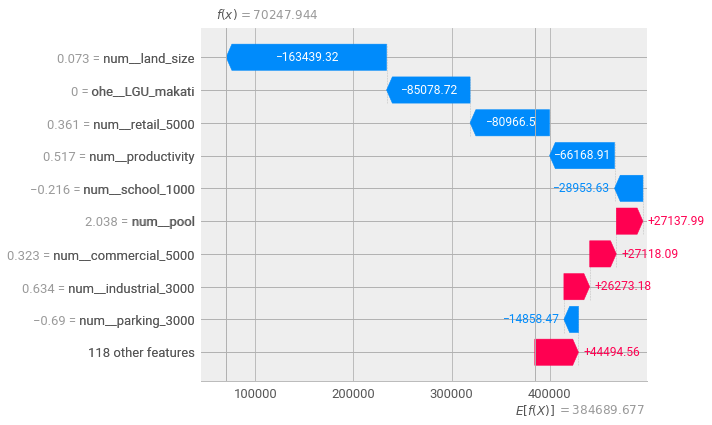

In [19]:
# waterfall plot

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
background = shap.maskers.Independent(X_train_proc) #shap.maskers.TabularPartitions(X, sample=100)

explainer = shap.Explainer(model['DT'][-1], background, link=shap.links.logit)
shap_value = explainer(pd.DataFrame(X_train_proc, columns = feature_names))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_value[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [20]:
# force plot for local explaination

shap.plots.initjs()
# visualize the first prediction's explanation
shap.plots.force(shap_value[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

# Explanation methods - Global

## Dalex

The general idea underlying the construction of PD profiles is to show how does the expected value of model prediction behave as a function of a selected explanatory variable. For a single model, one can construct an overall PD profile by using all observations from a dataset, or several profiles for sub-groups of the observations. Comparison of sub-group-specific profiles may provide important insight into, for instance, the stability of the model’s predictions.

In [21]:
# Partial-dependence profiles
m_prof = exp.model_profile(variables = ['land_size', 'bathrooms'])
display(m_prof.result)
m_prof.plot()

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


_vname_                _label_     _x_         _yhat_  _ids_
0    land_size  DecisionTreeRegressor   40.00  957125.420074      0
1    land_size  DecisionTreeRegressor   68.60  553318.589573      0
2    land_size  DecisionTreeRegressor   97.20  446551.230891      0
3    land_size  DecisionTreeRegressor  125.80  354652.243432      0
4    land_size  DecisionTreeRegressor  154.40  271745.983451      0
..         ...                    ...     ...            ...    ...
197  bathrooms  DecisionTreeRegressor    9.64  302948.909639      0
198  bathrooms  DecisionTreeRegressor    9.73  302948.909639      0
199  bathrooms  DecisionTreeRegressor    9.82  302948.909639      0
200  bathrooms  DecisionTreeRegressor    9.91  302948.909639      0
201  bathrooms  DecisionTreeRegressor   10.00  302948.909639      0

[202 rows x 5 columns]

A PD profile can be plotted on top of CP profiles. This is a very useful feature if we want to check how well does the former capture the latter. By specifying the argument geom = 'profiles' in the plot() method, we add the CP profiles to the plot of the PD profile.

In [22]:
# m_prof.plot(geom = 'profiles')

To obtain the profiles for categorical variables, in the code that follows we use the argument `variable_type = 'categorical'`. Additionally, in the call to the `plot()` method we indicate that we want to display the profiles only to categorical variables.

In [23]:
# In progress! - crashes kernel

# m_prof_cat = exp.model_profile(variable_type = 'categorical')
# display(m_prof_cat.result)
# # m_prof_cat.plot(variables = ['lgu_type', 'income_class'])

In [24]:
# Grouped Partial-dependence profiles
grouped_pd = exp.model_profile(groups = 'LGU', variables = ['land_size', 'bathrooms'])
grouped_pd.plot()

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]


Variable-importance: How important is an explanatory variable? We can use this for
- Model simplification: excluding variables that do not influence a model's predictions
- Model exploration: comparing variables' importance in different models may help in discovering interrelations between variables
- Domain-knowledge-based model validation: identification of most important variables may be helpful in assessing the validity of the model based on domain knowledge
- Knowledge generation: identification of important variables may lead to discovery of new factors involved in a particular mechanism

In [25]:
# Variable-importance Measures
mparts = exp.model_parts()
mparts.result
mparts.plot()

variable  dropout_loss                  label
0         _full_model_  8.119065e+04  DecisionTreeRegressor
1    fire_station_1000  8.119065e+04  DecisionTreeRegressor
2             lgu_type  8.119065e+04  DecisionTreeRegressor
3         transparency  8.119065e+04  DecisionTreeRegressor
4    fire_station_5000  8.119082e+04  DecisionTreeRegressor
..                 ...           ...                    ...
119           atm_3000  3.088596e+05  DecisionTreeRegressor
120        school_1000  5.181765e+05  DecisionTreeRegressor
121                LGU  8.193944e+05  DecisionTreeRegressor
122          land_size  8.238268e+05  DecisionTreeRegressor
123         _baseline_  1.069562e+06  DecisionTreeRegressor

[124 rows x 3 columns]

In [26]:
print(X_train.columns.tolist())

['LGU', 'infrastructure', 'resiliency', 'productivity', 'security', 'transparency', 'utilities', 'ac_unit', 'balcony', 'deck', 'fence', 'fireplace', 'fitness_center', 'garage', 'grass', 'library_books', 'local_airport', 'local_parking', 'meeting_room', 'park', 'pool', 'security.1', 'smoke_free', 'sports_basketball', 'sports_tennis', 'sports_volleyball', 'warehouse', 'yard', 'price_conditions', 'car_spaces', 'bedrooms', 'bathrooms', 'floor_area', 'land_size', 'cafe_1000', 'fast_food_1000', 'pub_1000', 'restaurant_1000', 'college_1000', 'kindergarten_1000', 'school_1000', 'university_1000', 'fuel_1000', 'parking_1000', 'atm_1000', 'bank_1000', 'clinic_1000', 'hospital_1000', 'pharmacy_1000', 'police_1000', 'townhall_1000', 'marketplace_1000', 'hotel_1000', 'residential_1000', 'commercial_1000', 'industrial_1000', 'retail_1000', 'supermarket_1000', 'fire_station_1000', 'government_1000', 'cafe_3000', 'fast_food_3000', 'pub_3000', 'restaurant_3000', 'college_3000', 'kindergarten_3000', 'sc

In [27]:
# Grouped variable-importance measures
grouped_mparts = exp.model_parts(variable_groups = {
    'cmci': ['infrastructure', 'resiliency', 'productivity', 'security', 'transparency', 'utilities'],
    'house_amenities': [ 'ac_unit', 'balcony', 'deck', 'fence', 'fireplace', 'fitness_center', 'garage',
                        'grass', 'library_books', 'local_airport', 'local_parking', 'meeting_room', 'park',
                        'pool', 'security.1', 'smoke_free', 'sports_basketball', 'sports_tennis',
                        'sports_volleyball', 'warehouse', 'yard'],
    'house_characteristics': ['price_conditions', 'car_spaces', 'bedrooms', 'bathrooms', 'floor_area', 'land_size'],
    'LOI_1000': ['cafe_1000', 'fast_food_1000', 'pub_1000', 'restaurant_1000', 'college_1000', 'kindergarten_1000',
                 'school_1000', 'university_1000', 'fuel_1000', 'parking_1000', 'atm_1000', 'bank_1000', 'clinic_1000',
                 'hospital_1000', 'pharmacy_1000', 'police_1000', 'townhall_1000', 'marketplace_1000', 'hotel_1000',
                 'residential_1000', 'commercial_1000', 'industrial_1000', 'retail_1000', 'supermarket_1000',
                 'fire_station_1000', 'government_1000'],
    'LOI_3000': ['cafe_3000', 'fast_food_3000', 'pub_3000', 'restaurant_3000', 'college_3000', 'kindergarten_3000',
                 'school_3000', 'university_3000', 'fuel_3000', 'parking_3000', 'atm_3000', 'bank_3000', 'clinic_3000',
                 'hospital_3000', 'pharmacy_3000', 'police_3000', 'townhall_3000', 'marketplace_3000', 'hotel_3000',
                 'residential_3000', 'commercial_3000', 'industrial_3000', 'retail_3000', 'supermarket_3000',
                 'fire_station_3000', 'government_3000'],
    'LOI_5000': ['cafe_5000', 'fast_food_5000', 'pub_5000', 'restaurant_5000', 'college_5000', 'kindergarten_5000',
                 'school_5000', 'university_5000', 'fuel_5000', 'parking_5000', 'atm_5000', 'bank_5000', 'clinic_5000',
                 'hospital_5000', 'pharmacy_5000', 'police_5000', 'townhall_5000', 'marketplace_5000', 'hotel_5000',
                 'residential_5000', 'commercial_5000', 'industrial_5000', 'retail_5000', 'supermarket_5000',
                 'fire_station_5000', 'government_5000'],
    'socio-economic': ['LGU', 'poverty_inc', 'subs_inc', 'lgu_type', 'income_class', 'anreg_income_2021',
                       'capex_2021', 'socex_2021', 'pop_2022', 'growth_5years', 'growth_10years']
})
grouped_mparts.result
grouped_mparts.plot()

variable  dropout_loss                  label
0           _full_model_  8.477609e+04  DecisionTreeRegressor
1                   cmci  1.084044e+05  DecisionTreeRegressor
2        house_amenities  3.380529e+05  DecisionTreeRegressor
3               LOI_3000  4.983558e+05  DecisionTreeRegressor
4               LOI_5000  4.989692e+05  DecisionTreeRegressor
5               LOI_1000  6.847536e+05  DecisionTreeRegressor
6  house_characteristics  7.587023e+05  DecisionTreeRegressor
7         socio-economic  7.823229e+05  DecisionTreeRegressor
8             _baseline_  1.027025e+06  DecisionTreeRegressor

In [28]:
# Shapley
obs_shap = exp.predict_parts(obs, type = 'shap')
obs_shap.result
obs_shap.plot()

# Might take a while!

variable  contribution      variable_name variable_value  \
0           hotel_1000 = 0.0  -2160.559750         hotel_1000              0   
1         parking_1000 = 6.0  -1348.546631       parking_1000              6   
2      fast_food_3000 = 74.0  -9757.852957     fast_food_3000             74   
3    kindergarten_5000 = 7.0    653.027955  kindergarten_5000              7   
4            cafe_1000 = 5.0   -423.518947          cafe_1000              5   
..                       ...           ...                ...            ...   
117    growth_5years = 2.389      0.905084      growth_5years        2.38939   
118        poverty_inc = 0.6     -0.106737        poverty_inc            0.6   
119          lgu_type = City      0.000000           lgu_type           City   
120  fire_station_1000 = 0.0      0.000000  fire_station_1000              0   
121       transparency = 3.0      0.000000       transparency              3   

     sign                  label  B  
0    -1.0  DecisionTreeRegressor  1  
1    -1.0  DecisionTreeRegressor  1  
2    -1.0  DecisionTreeRegressor  1  
3     1.0  DecisionTreeRegressor  1  
4    -1.0  DecisionTreeRegressor  1  
..    ...                    ... ..  
117   1.0  DecisionTreeRegressor  0  
118  -1.0  DecisionTreeRegressor  0  
119   0.0  DecisionTreeRegressor  0  
120   0.0  DecisionTreeRegressor  0  
121   0.0  DecisionTreeRegressor  0  

[3172 rows x 7 columns]

## SHAP

In [30]:
# this takes a minute or two since we are explaining thousands samples in a model with over a thousand trees
model_global = model['DT'][-1]
samples = 100

try:
    explainer = shap.TreeExplainer(model_global)
except:
    explainer = shap.KernelExplainer(model_global.predict, X_train_proc[:samples]) # ) keep_index=True)
    
# shap values    
shap_values = explainer.shap_values(X_train_proc)

**Bar Plot**: This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

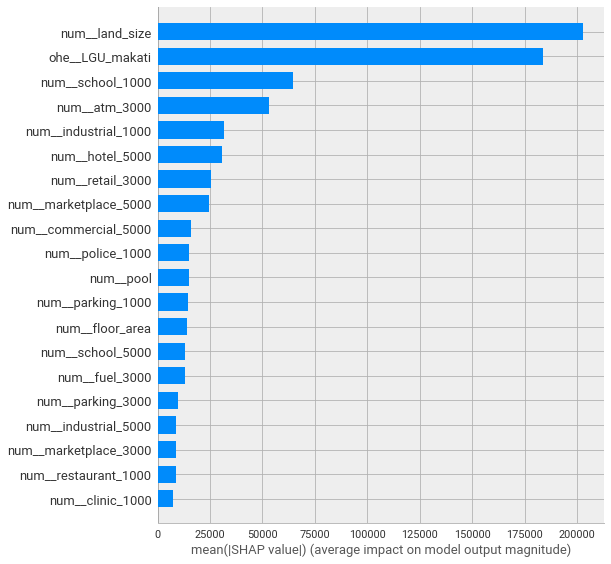

In [33]:
# bar plot of feature importance
shap.summary_plot(shap_values, X_train_proc, plot_type="bar", feature_names = feature_names)

**SHAP Summary Plot**: Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual

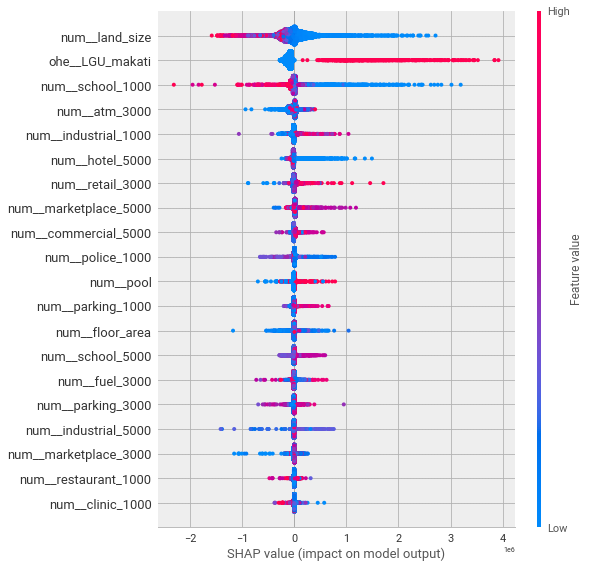

In [34]:
shap.summary_plot(shap_values, X_train_proc, feature_names = feature_names)

The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

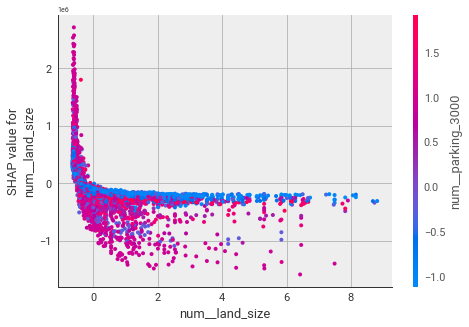

In [36]:
shap.dependence_plot("num__land_size", shap_values, X_train_proc, interaction_index="num__parking_3000", feature_names = feature_names)

**Force Plot**: Another way to visualize the same explanation is to use a force plot.
If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [38]:
# Force plot
# # visualize all the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train_proc[:1000,:], feature_names = feature_names)

# Stability

Compares the distribution of the target variable in the test dataset to a training data set that was used to develop the model

## Population Stability Index (PSI)

In [39]:
# cont = X_train.select_dtypes(include = ['int64', 'float64']).columns.tolist()
# cat = X_train.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

psi_list(X_train[cont], X_test[cont])

Stability index for column infrastructure is 1.7103032356617662e-07
There is no change or shift in the distributions of both datasets for column infrastructure.

Stability index for column resiliency is 3.470085732948897e-07
There is no change or shift in the distributions of both datasets for column resiliency.

Stability index for column productivity is 3.4700820464675246e-07
There is no change or shift in the distributions of both datasets for column productivity.

Stability index for column security is 8.02254241395458e-08
There is no change or shift in the distributions of both datasets for column security.

Stability index for column transparency is 0.0
There is no change or shift in the distributions of both datasets for column transparency.

Stability index for column utilities is 7.668229194354695e-08
There is no change or shift in the distributions of both datasets for column utilities.

Stability index for column ac_unit is 0.0003121625776704974
There is no change or shift i

([], [])

## Page Hinkley
This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley does not signal warning zones, only change detections.
This detector implements the CUSUM control chart for detecting changes. 
This implementation also supports the two-sided Page-Hinkley test to detect increasing and decreasing changes in the mean of the input values.

In [40]:
# In progress
PageHinkley(X_train[cont], X_test[cont])

Change detected at index 6021 for column: infrastructure with input value: 82.0
Change detected at index 8068 for column: infrastructure with input value: 100.0
Change detected at index 10568 for column: infrastructure with input value: 89.0
Change detected at index 10798 for column: infrastructure with input value: 144.0
Change detected at index 12968 for column: infrastructure with input value: 82.0
Change detected at index 13479 for column: infrastructure with input value: 100.0
Change detected at index 14105 for column: infrastructure with input value: 89.0
Change detected at index 14162 for column: infrastructure with input value: 144.0
Change detected at index 6033 for column: resiliency with input value: 13.0
Change detected at index 8070 for column: resiliency with input value: 25.0
Change detected at index 10567 for column: resiliency with input value: 75.0
Change detected at index 13483 for column: resiliency with input value: 25.0
Change detected at index 14104 for column: r

Change detected at index 26 for column: land_size with input value: 1000.0
Change detected at index 63 for column: land_size with input value: 920.0
Change detected at index 92 for column: land_size with input value: 53.66
Change detected at index 121 for column: land_size with input value: 113.0
Change detected at index 152 for column: land_size with input value: 748.0
Change detected at index 181 for column: land_size with input value: 79.0
Change detected at index 210 for column: land_size with input value: 1230.0
Change detected at index 239 for column: land_size with input value: 600.0
Change detected at index 272 for column: land_size with input value: 620.0
Change detected at index 301 for column: land_size with input value: 232.0
Change detected at index 330 for column: land_size with input value: 608.0
Change detected at index 359 for column: land_size with input value: 66.0
Change detected at index 388 for column: land_size with input value: 417.0
Change detected at index 417

Change detected at index 3648 for column: fast_food_1000 with input value: 56
Change detected at index 3677 for column: fast_food_1000 with input value: 18
Change detected at index 3711 for column: fast_food_1000 with input value: 37
Change detected at index 3755 for column: fast_food_1000 with input value: 56
Change detected at index 3784 for column: fast_food_1000 with input value: 56
Change detected at index 3827 for column: fast_food_1000 with input value: 36
Change detected at index 3885 for column: fast_food_1000 with input value: 40
Change detected at index 3914 for column: fast_food_1000 with input value: 39
Change detected at index 3952 for column: fast_food_1000 with input value: 36
Change detected at index 3986 for column: fast_food_1000 with input value: 56
Change detected at index 4015 for column: fast_food_1000 with input value: 56
Change detected at index 4044 for column: fast_food_1000 with input value: 19
Change detected at index 4076 for column: fast_food_1000 with in

Change detected at index 2460 for column: restaurant_1000 with input value: 284
Change detected at index 2489 for column: restaurant_1000 with input value: 4
Change detected at index 2518 for column: restaurant_1000 with input value: 56
Change detected at index 2547 for column: restaurant_1000 with input value: 4
Change detected at index 2576 for column: restaurant_1000 with input value: 144
Change detected at index 2608 for column: restaurant_1000 with input value: 156
Change detected at index 2637 for column: restaurant_1000 with input value: 78
Change detected at index 2666 for column: restaurant_1000 with input value: 96
Change detected at index 2696 for column: restaurant_1000 with input value: 96
Change detected at index 2725 for column: restaurant_1000 with input value: 48
Change detected at index 2754 for column: restaurant_1000 with input value: 25
Change detected at index 2784 for column: restaurant_1000 with input value: 94
Change detected at index 2813 for column: restauran

Change detected at index 2032 for column: kindergarten_1000 with input value: 1
Change detected at index 6044 for column: kindergarten_1000 with input value: 5
Change detected at index 10695 for column: kindergarten_1000 with input value: 1
Change detected at index 10814 for column: kindergarten_1000 with input value: 10
Change detected at index 11053 for column: kindergarten_1000 with input value: 10
Change detected at index 12982 for column: kindergarten_1000 with input value: 5
Change detected at index 13507 for column: kindergarten_1000 with input value: 5
Change detected at index 14150 for column: kindergarten_1000 with input value: 1
Change detected at index 14187 for column: kindergarten_1000 with input value: 7
Change detected at index 15 for column: school_1000 with input value: 8
Change detected at index 1583 for column: school_1000 with input value: 9
Change detected at index 2002 for column: school_1000 with input value: 12
Change detected at index 2104 for column: school_1

Change detected at index 3647 for column: atm_1000 with input value: 10
Change detected at index 4017 for column: atm_1000 with input value: 7
Change detected at index 4422 for column: atm_1000 with input value: 7
Change detected at index 4573 for column: atm_1000 with input value: 10
Change detected at index 4689 for column: atm_1000 with input value: 10
Change detected at index 4786 for column: atm_1000 with input value: 10
Change detected at index 4994 for column: atm_1000 with input value: 10
Change detected at index 5219 for column: atm_1000 with input value: 12
Change detected at index 5621 for column: atm_1000 with input value: 10
Change detected at index 5975 for column: atm_1000 with input value: 10
Change detected at index 6026 for column: atm_1000 with input value: 20
Change detected at index 6156 for column: atm_1000 with input value: 11
Change detected at index 6263 for column: atm_1000 with input value: 22
Change detected at index 7704 for column: atm_1000 with input valu

Change detected at index 2717 for column: hospital_1000 with input value: 4
Change detected at index 3676 for column: hospital_1000 with input value: 7
Change detected at index 4805 for column: hospital_1000 with input value: 7
Change detected at index 5597 for column: hospital_1000 with input value: 7
Change detected at index 6985 for column: hospital_1000 with input value: 3
Change detected at index 7564 for column: hospital_1000 with input value: 3
Change detected at index 7665 for column: hospital_1000 with input value: 4
Change detected at index 7845 for column: hospital_1000 with input value: 12
Change detected at index 7999 for column: hospital_1000 with input value: 12
Change detected at index 10635 for column: hospital_1000 with input value: 2
Change detected at index 10916 for column: hospital_1000 with input value: 5
Change detected at index 11273 for column: hospital_1000 with input value: 6
Change detected at index 11444 for column: hospital_1000 with input value: 6
Change

Change detected at index 7709 for column: townhall_1000 with input value: 30
Change detected at index 7900 for column: townhall_1000 with input value: 30
Change detected at index 8049 for column: townhall_1000 with input value: 30
Change detected at index 10578 for column: townhall_1000 with input value: 8
Change detected at index 10637 for column: townhall_1000 with input value: 8
Change detected at index 10799 for column: townhall_1000 with input value: 11
Change detected at index 10835 for column: townhall_1000 with input value: 18
Change detected at index 10941 for column: townhall_1000 with input value: 15
Change detected at index 11027 for column: townhall_1000 with input value: 13
Change detected at index 11101 for column: townhall_1000 with input value: 18
Change detected at index 11977 for column: townhall_1000 with input value: 5
Change detected at index 12115 for column: townhall_1000 with input value: 8
Change detected at index 12841 for column: townhall_1000 with input val

Change detected at index 10942 for column: commercial_1000 with input value: 13
Change detected at index 10976 for column: commercial_1000 with input value: 46
Change detected at index 11007 for column: commercial_1000 with input value: 46
Change detected at index 11036 for column: commercial_1000 with input value: 37
Change detected at index 11065 for column: commercial_1000 with input value: 37
Change detected at index 11097 for column: commercial_1000 with input value: 46
Change detected at index 11235 for column: commercial_1000 with input value: 104
Change detected at index 11264 for column: commercial_1000 with input value: 6
Change detected at index 11293 for column: commercial_1000 with input value: 6
Change detected at index 11322 for column: commercial_1000 with input value: 35
Change detected at index 11351 for column: commercial_1000 with input value: 6
Change detected at index 11380 for column: commercial_1000 with input value: 6
Change detected at index 11409 for column: 

Change detected at index 12928 for column: retail_1000 with input value: 9
Change detected at index 12985 for column: retail_1000 with input value: 17
Change detected at index 13045 for column: retail_1000 with input value: 21
Change detected at index 13291 for column: retail_1000 with input value: 23
Change detected at index 13474 for column: retail_1000 with input value: 31
Change detected at index 13671 for column: retail_1000 with input value: 13
Change detected at index 14084 for column: retail_1000 with input value: 14
Change detected at index 14163 for column: retail_1000 with input value: 35
Change detected at index 14231 for column: retail_1000 with input value: 38
Change detected at index 7746 for column: supermarket_1000 with input value: 1
Change detected at index 11358 for column: supermarket_1000 with input value: 1
Change detected at index 11786 for column: supermarket_1000 with input value: 1
Change detected at index 11889 for column: supermarket_1000 with input value: 

Change detected at index 3255 for column: fast_food_3000 with input value: 129
Change detected at index 3284 for column: fast_food_3000 with input value: 270
Change detected at index 3313 for column: fast_food_3000 with input value: 338
Change detected at index 3344 for column: fast_food_3000 with input value: 259
Change detected at index 3373 for column: fast_food_3000 with input value: 242
Change detected at index 3403 for column: fast_food_3000 with input value: 288
Change detected at index 3432 for column: fast_food_3000 with input value: 110
Change detected at index 3461 for column: fast_food_3000 with input value: 247
Change detected at index 3490 for column: fast_food_3000 with input value: 279
Change detected at index 3519 for column: fast_food_3000 with input value: 259
Change detected at index 3548 for column: fast_food_3000 with input value: 279
Change detected at index 3577 for column: fast_food_3000 with input value: 129
Change detected at index 3606 for column: fast_food_

Change detected at index 11734 for column: pub_3000 with input value: 6
Change detected at index 11952 for column: pub_3000 with input value: 32
Change detected at index 12103 for column: pub_3000 with input value: 31
Change detected at index 12600 for column: pub_3000 with input value: 16
Change detected at index 12833 for column: pub_3000 with input value: 21
Change detected at index 12927 for column: pub_3000 with input value: 13
Change detected at index 12971 for column: pub_3000 with input value: 24
Change detected at index 13292 for column: pub_3000 with input value: 11
Change detected at index 13460 for column: pub_3000 with input value: 26
Change detected at index 14162 for column: pub_3000 with input value: 15
Change detected at index 14327 for column: pub_3000 with input value: 16
Change detected at index 28 for column: restaurant_3000 with input value: 230
Change detected at index 58 for column: restaurant_3000 with input value: 230
Change detected at index 87 for column: re

Change detected at index 7657 for column: college_3000 with input value: 63
Change detected at index 7692 for column: college_3000 with input value: 63
Change detected at index 7735 for column: college_3000 with input value: 63
Change detected at index 7770 for column: college_3000 with input value: 63
Change detected at index 7807 for column: college_3000 with input value: 57
Change detected at index 7853 for column: college_3000 with input value: 57
Change detected at index 7885 for column: college_3000 with input value: 67
Change detected at index 7914 for column: college_3000 with input value: 63
Change detected at index 7950 for column: college_3000 with input value: 63
Change detected at index 7979 for column: college_3000 with input value: 57
Change detected at index 8038 for column: college_3000 with input value: 63
Change detected at index 8067 for column: college_3000 with input value: 57
Change detected at index 8211 for column: college_3000 with input value: 20
Change detec

Change detected at index 7079 for column: school_3000 with input value: 76
Change detected at index 7108 for column: school_3000 with input value: 106
Change detected at index 7138 for column: school_3000 with input value: 127
Change detected at index 7167 for column: school_3000 with input value: 126
Change detected at index 7198 for column: school_3000 with input value: 126
Change detected at index 7227 for column: school_3000 with input value: 127
Change detected at index 7258 for column: school_3000 with input value: 126
Change detected at index 7287 for column: school_3000 with input value: 58
Change detected at index 7317 for column: school_3000 with input value: 126
Change detected at index 7346 for column: school_3000 with input value: 130
Change detected at index 7379 for column: school_3000 with input value: 127
Change detected at index 7408 for column: school_3000 with input value: 99
Change detected at index 7437 for column: school_3000 with input value: 68
Change detected 

Change detected at index 5204 for column: fuel_3000 with input value: 47
Change detected at index 5233 for column: fuel_3000 with input value: 97
Change detected at index 5294 for column: fuel_3000 with input value: 97
Change detected at index 5331 for column: fuel_3000 with input value: 80
Change detected at index 5365 for column: fuel_3000 with input value: 83
Change detected at index 5395 for column: fuel_3000 with input value: 95
Change detected at index 5424 for column: fuel_3000 with input value: 83
Change detected at index 5453 for column: fuel_3000 with input value: 74
Change detected at index 5492 for column: fuel_3000 with input value: 78
Change detected at index 5534 for column: fuel_3000 with input value: 99
Change detected at index 5563 for column: fuel_3000 with input value: 66
Change detected at index 5624 for column: fuel_3000 with input value: 99
Change detected at index 5653 for column: fuel_3000 with input value: 74
Change detected at index 5683 for column: fuel_3000

Change detected at index 11181 for column: parking_3000 with input value: 300
Change detected at index 11210 for column: parking_3000 with input value: 238
Change detected at index 11246 for column: parking_3000 with input value: 263
Change detected at index 11275 for column: parking_3000 with input value: 73
Change detected at index 11304 for column: parking_3000 with input value: 146
Change detected at index 11333 for column: parking_3000 with input value: 151
Change detected at index 11362 for column: parking_3000 with input value: 161
Change detected at index 11391 for column: parking_3000 with input value: 54
Change detected at index 11420 for column: parking_3000 with input value: 186
Change detected at index 11449 for column: parking_3000 with input value: 115
Change detected at index 11625 for column: parking_3000 with input value: 92
Change detected at index 11654 for column: parking_3000 with input value: 92
Change detected at index 11687 for column: parking_3000 with input v

Change detected at index 6069 for column: bank_3000 with input value: 461
Change detected at index 6100 for column: bank_3000 with input value: 461
Change detected at index 6129 for column: bank_3000 with input value: 481
Change detected at index 6161 for column: bank_3000 with input value: 461
Change detected at index 6190 for column: bank_3000 with input value: 363
Change detected at index 6219 for column: bank_3000 with input value: 297
Change detected at index 6248 for column: bank_3000 with input value: 461
Change detected at index 6277 for column: bank_3000 with input value: 348
Change detected at index 6306 for column: bank_3000 with input value: 329
Change detected at index 6335 for column: bank_3000 with input value: 359
Change detected at index 6366 for column: bank_3000 with input value: 492
Change detected at index 6395 for column: bank_3000 with input value: 149
Change detected at index 6424 for column: bank_3000 with input value: 266
Change detected at index 6454 for colu

Change detected at index 2023 for column: hospital_3000 with input value: 10
Change detected at index 2644 for column: hospital_3000 with input value: 20
Change detected at index 2708 for column: hospital_3000 with input value: 17
Change detected at index 2810 for column: hospital_3000 with input value: 36
Change detected at index 2882 for column: hospital_3000 with input value: 20
Change detected at index 2971 for column: hospital_3000 with input value: 36
Change detected at index 3013 for column: hospital_3000 with input value: 20
Change detected at index 3123 for column: hospital_3000 with input value: 22
Change detected at index 3154 for column: hospital_3000 with input value: 25
Change detected at index 3228 for column: hospital_3000 with input value: 23
Change detected at index 3283 for column: hospital_3000 with input value: 20
Change detected at index 3316 for column: hospital_3000 with input value: 18
Change detected at index 3377 for column: hospital_3000 with input value: 36

Change detected at index 5613 for column: police_3000 with input value: 30
Change detected at index 5862 for column: police_3000 with input value: 21
Change detected at index 5959 for column: police_3000 with input value: 14
Change detected at index 6022 for column: police_3000 with input value: 31
Change detected at index 6588 for column: police_3000 with input value: 39
Change detected at index 6667 for column: police_3000 with input value: 39
Change detected at index 6737 for column: police_3000 with input value: 35
Change detected at index 6768 for column: police_3000 with input value: 34
Change detected at index 6797 for column: police_3000 with input value: 34
Change detected at index 6957 for column: police_3000 with input value: 33
Change detected at index 6997 for column: police_3000 with input value: 39
Change detected at index 7026 for column: police_3000 with input value: 36
Change detected at index 7124 for column: police_3000 with input value: 39
Change detected at index 

Change detected at index 10568 for column: marketplace_3000 with input value: 27
Change detected at index 10634 for column: marketplace_3000 with input value: 38
Change detected at index 10781 for column: marketplace_3000 with input value: 35
Change detected at index 11956 for column: marketplace_3000 with input value: 19
Change detected at index 12100 for column: marketplace_3000 with input value: 20
Change detected at index 12555 for column: marketplace_3000 with input value: 14
Change detected at index 12800 for column: marketplace_3000 with input value: 14
Change detected at index 12942 for column: marketplace_3000 with input value: 19
Change detected at index 12975 for column: marketplace_3000 with input value: 21
Change detected at index 13046 for column: marketplace_3000 with input value: 23
Change detected at index 13284 for column: marketplace_3000 with input value: 12
Change detected at index 13313 for column: marketplace_3000 with input value: 19
Change detected at index 133

Change detected at index 11505 for column: residential_3000 with input value: 125
Change detected at index 11624 for column: residential_3000 with input value: 132
Change detected at index 11653 for column: residential_3000 with input value: 132
Change detected at index 11803 for column: residential_3000 with input value: 133
Change detected at index 11934 for column: residential_3000 with input value: 124
Change detected at index 11963 for column: residential_3000 with input value: 388
Change detected at index 12013 for column: residential_3000 with input value: 389
Change detected at index 12047 for column: residential_3000 with input value: 404
Change detected at index 12095 for column: residential_3000 with input value: 386
Change detected at index 12254 for column: residential_3000 with input value: 277
Change detected at index 12284 for column: residential_3000 with input value: 277
Change detected at index 12315 for column: residential_3000 with input value: 231
Change detected 

Change detected at index 6022 for column: industrial_3000 with input value: 50
Change detected at index 6070 for column: industrial_3000 with input value: 53
Change detected at index 6146 for column: industrial_3000 with input value: 53
Change detected at index 6177 for column: industrial_3000 with input value: 53
Change detected at index 6206 for column: industrial_3000 with input value: 46
Change detected at index 6235 for column: industrial_3000 with input value: 53
Change detected at index 6296 for column: industrial_3000 with input value: 53
Change detected at index 7659 for column: industrial_3000 with input value: 48
Change detected at index 7758 for column: industrial_3000 with input value: 154
Change detected at index 7832 for column: industrial_3000 with input value: 155
Change detected at index 7861 for column: industrial_3000 with input value: 24
Change detected at index 7892 for column: industrial_3000 with input value: 57
Change detected at index 7938 for column: industri

Change detected at index 7845 for column: supermarket_3000 with input value: 3
Change detected at index 10858 for column: supermarket_3000 with input value: 2
Change detected at index 11302 for column: supermarket_3000 with input value: 2
Change detected at index 11775 for column: supermarket_3000 with input value: 2
Change detected at index 11890 for column: supermarket_3000 with input value: 3
Change detected at index 12368 for column: supermarket_3000 with input value: 1
Change detected at index 12960 for column: supermarket_3000 with input value: 2
Change detected at index 13383 for column: supermarket_3000 with input value: 3
Change detected at index 14237 for column: supermarket_3000 with input value: 3
Change detected at index 2894 for column: fire_station_3000 with input value: 1
Change detected at index 12194 for column: fire_station_3000 with input value: 1
Change detected at index 25 for column: government_3000 with input value: 7
Change detected at index 191 for column: gov

Change detected at index 5650 for column: fast_food_5000 with input value: 785
Change detected at index 5679 for column: fast_food_5000 with input value: 785
Change detected at index 5708 for column: fast_food_5000 with input value: 438
Change detected at index 5737 for column: fast_food_5000 with input value: 616
Change detected at index 5766 for column: fast_food_5000 with input value: 706
Change detected at index 5795 for column: fast_food_5000 with input value: 279
Change detected at index 5824 for column: fast_food_5000 with input value: 376
Change detected at index 5853 for column: fast_food_5000 with input value: 723
Change detected at index 5886 for column: fast_food_5000 with input value: 648
Change detected at index 5915 for column: fast_food_5000 with input value: 631
Change detected at index 5944 for column: fast_food_5000 with input value: 407
Change detected at index 5973 for column: fast_food_5000 with input value: 785
Change detected at index 6002 for column: fast_food_

Change detected at index 2821 for column: restaurant_5000 with input value: 978
Change detected at index 2850 for column: restaurant_5000 with input value: 423
Change detected at index 2879 for column: restaurant_5000 with input value: 423
Change detected at index 2908 for column: restaurant_5000 with input value: 824
Change detected at index 2937 for column: restaurant_5000 with input value: 198
Change detected at index 2966 for column: restaurant_5000 with input value: 600
Change detected at index 2995 for column: restaurant_5000 with input value: 793
Change detected at index 3024 for column: restaurant_5000 with input value: 187
Change detected at index 3053 for column: restaurant_5000 with input value: 1056
Change detected at index 3082 for column: restaurant_5000 with input value: 978
Change detected at index 3111 for column: restaurant_5000 with input value: 1169
Change detected at index 3140 for column: restaurant_5000 with input value: 485
Change detected at index 3169 for colu

Change detected at index 7717 for column: college_5000 with input value: 113
Change detected at index 7791 for column: college_5000 with input value: 113
Change detected at index 7891 for column: college_5000 with input value: 113
Change detected at index 7941 for column: college_5000 with input value: 113
Change detected at index 7990 for column: college_5000 with input value: 113
Change detected at index 8019 for column: college_5000 with input value: 113
Change detected at index 10581 for column: college_5000 with input value: 20
Change detected at index 10610 for column: college_5000 with input value: 24
Change detected at index 10682 for column: college_5000 with input value: 24
Change detected at index 10725 for column: college_5000 with input value: 32
Change detected at index 10784 for column: college_5000 with input value: 32
Change detected at index 10813 for column: college_5000 with input value: 89
Change detected at index 10842 for column: college_5000 with input value: 95

Change detected at index 12841 for column: school_5000 with input value: 258
Change detected at index 12925 for column: school_5000 with input value: 248
Change detected at index 12954 for column: school_5000 with input value: 316
Change detected at index 12983 for column: school_5000 with input value: 307
Change detected at index 13208 for column: school_5000 with input value: 264
Change detected at index 13259 for column: school_5000 with input value: 257
Change detected at index 13293 for column: school_5000 with input value: 258
Change detected at index 13352 for column: school_5000 with input value: 277
Change detected at index 13381 for column: school_5000 with input value: 363
Change detected at index 14104 for column: school_5000 with input value: 218
Change detected at index 14133 for column: school_5000 with input value: 214
Change detected at index 14162 for column: school_5000 with input value: 297
Change detected at index 14191 for column: school_5000 with input value: 314

Change detected at index 12299 for column: fuel_5000 with input value: 260
Change detected at index 12330 for column: fuel_5000 with input value: 242
Change detected at index 12359 for column: fuel_5000 with input value: 194
Change detected at index 12388 for column: fuel_5000 with input value: 124
Change detected at index 12417 for column: fuel_5000 with input value: 102
Change detected at index 12446 for column: fuel_5000 with input value: 102
Change detected at index 12475 for column: fuel_5000 with input value: 155
Change detected at index 12504 for column: fuel_5000 with input value: 197
Change detected at index 12533 for column: fuel_5000 with input value: 202
Change detected at index 12562 for column: fuel_5000 with input value: 183
Change detected at index 12617 for column: fuel_5000 with input value: 194
Change detected at index 12714 for column: fuel_5000 with input value: 194
Change detected at index 12743 for column: fuel_5000 with input value: 194
Change detected at index 

Change detected at index 4923 for column: atm_5000 with input value: 106
Change detected at index 4952 for column: atm_5000 with input value: 143
Change detected at index 4983 for column: atm_5000 with input value: 132
Change detected at index 5013 for column: atm_5000 with input value: 143
Change detected at index 5042 for column: atm_5000 with input value: 146
Change detected at index 5071 for column: atm_5000 with input value: 147
Change detected at index 5104 for column: atm_5000 with input value: 143
Change detected at index 5134 for column: atm_5000 with input value: 143
Change detected at index 5163 for column: atm_5000 with input value: 147
Change detected at index 5192 for column: atm_5000 with input value: 143
Change detected at index 5231 for column: atm_5000 with input value: 115
Change detected at index 5260 for column: atm_5000 with input value: 106
Change detected at index 5292 for column: atm_5000 with input value: 132
Change detected at index 5321 for column: atm_5000 

Change detected at index 11716 for column: bank_5000 with input value: 190
Change detected at index 11745 for column: bank_5000 with input value: 238
Change detected at index 11855 for column: bank_5000 with input value: 252
Change detected at index 11951 for column: bank_5000 with input value: 1043
Change detected at index 12017 for column: bank_5000 with input value: 966
Change detected at index 12046 for column: bank_5000 with input value: 854
Change detected at index 12094 for column: bank_5000 with input value: 1006
Change detected at index 12249 for column: bank_5000 with input value: 756
Change detected at index 12297 for column: bank_5000 with input value: 774
Change detected at index 12326 for column: bank_5000 with input value: 612
Change detected at index 12355 for column: bank_5000 with input value: 612
Change detected at index 12385 for column: bank_5000 with input value: 527
Change detected at index 12414 for column: bank_5000 with input value: 132
Change detected at inde

Change detected at index 10584 for column: hospital_5000 with input value: 18
Change detected at index 10784 for column: hospital_5000 with input value: 23
Change detected at index 10813 for column: hospital_5000 with input value: 66
Change detected at index 10845 for column: hospital_5000 with input value: 66
Change detected at index 10874 for column: hospital_5000 with input value: 66
Change detected at index 10913 for column: hospital_5000 with input value: 66
Change detected at index 10978 for column: hospital_5000 with input value: 66
Change detected at index 11015 for column: hospital_5000 with input value: 66
Change detected at index 11079 for column: hospital_5000 with input value: 66
Change detected at index 11108 for column: hospital_5000 with input value: 63
Change detected at index 11205 for column: hospital_5000 with input value: 66
Change detected at index 11889 for column: hospital_5000 with input value: 25
Change detected at index 11955 for column: hospital_5000 with in

Change detected at index 5852 for column: police_5000 with input value: 61
Change detected at index 5898 for column: police_5000 with input value: 54
Change detected at index 5946 for column: police_5000 with input value: 61
Change detected at index 5975 for column: police_5000 with input value: 54
Change detected at index 6011 for column: police_5000 with input value: 54
Change detected at index 6040 for column: police_5000 with input value: 74
Change detected at index 7644 for column: police_5000 with input value: 70
Change detected at index 7673 for column: police_5000 with input value: 76
Change detected at index 7746 for column: police_5000 with input value: 89
Change detected at index 7775 for column: police_5000 with input value: 82
Change detected at index 7894 for column: police_5000 with input value: 89
Change detected at index 7939 for column: police_5000 with input value: 90
Change detected at index 10568 for column: police_5000 with input value: 51
Change detected at index

Change detected at index 963 for column: marketplace_5000 with input value: 43
Change detected at index 994 for column: marketplace_5000 with input value: 43
Change detected at index 1095 for column: marketplace_5000 with input value: 43
Change detected at index 1156 for column: marketplace_5000 with input value: 44
Change detected at index 1269 for column: marketplace_5000 with input value: 32
Change detected at index 1319 for column: marketplace_5000 with input value: 43
Change detected at index 1353 for column: marketplace_5000 with input value: 43
Change detected at index 1463 for column: marketplace_5000 with input value: 43
Change detected at index 1508 for column: marketplace_5000 with input value: 43
Change detected at index 1580 for column: marketplace_5000 with input value: 32
Change detected at index 1674 for column: marketplace_5000 with input value: 44
Change detected at index 1703 for column: marketplace_5000 with input value: 32
Change detected at index 1754 for column: 

Change detected at index 12922 for column: hotel_5000 with input value: 36
Change detected at index 12951 for column: hotel_5000 with input value: 44
Change detected at index 12980 for column: hotel_5000 with input value: 68
Change detected at index 13270 for column: hotel_5000 with input value: 40
Change detected at index 13299 for column: hotel_5000 with input value: 47
Change detected at index 13379 for column: hotel_5000 with input value: 53
Change detected at index 13418 for column: hotel_5000 with input value: 110
Change detected at index 14128 for column: hotel_5000 with input value: 58
Change detected at index 14157 for column: hotel_5000 with input value: 29
Change detected at index 14186 for column: hotel_5000 with input value: 74
Change detected at index 14327 for column: hotel_5000 with input value: 88
Change detected at index 34 for column: residential_5000 with input value: 367
Change detected at index 63 for column: residential_5000 with input value: 367
Change detected 

Change detected at index 7372 for column: commercial_5000 with input value: 236
Change detected at index 7405 for column: commercial_5000 with input value: 297
Change detected at index 7434 for column: commercial_5000 with input value: 182
Change detected at index 7463 for column: commercial_5000 with input value: 132
Change detected at index 7493 for column: commercial_5000 with input value: 220
Change detected at index 7525 for column: commercial_5000 with input value: 349
Change detected at index 7554 for column: commercial_5000 with input value: 132
Change detected at index 7583 for column: commercial_5000 with input value: 132
Change detected at index 7612 for column: commercial_5000 with input value: 306
Change detected at index 7641 for column: commercial_5000 with input value: 306
Change detected at index 7670 for column: commercial_5000 with input value: 380
Change detected at index 7699 for column: commercial_5000 with input value: 380
Change detected at index 7728 for column

Change detected at index 448 for column: retail_5000 with input value: 161
Change detected at index 477 for column: retail_5000 with input value: 112
Change detected at index 506 for column: retail_5000 with input value: 112
Change detected at index 535 for column: retail_5000 with input value: 114
Change detected at index 565 for column: retail_5000 with input value: 161
Change detected at index 594 for column: retail_5000 with input value: 114
Change detected at index 623 for column: retail_5000 with input value: 119
Change detected at index 652 for column: retail_5000 with input value: 182
Change detected at index 684 for column: retail_5000 with input value: 182
Change detected at index 732 for column: retail_5000 with input value: 182
Change detected at index 761 for column: retail_5000 with input value: 161
Change detected at index 793 for column: retail_5000 with input value: 182
Change detected at index 824 for column: retail_5000 with input value: 161
Change detected at index 

Change detected at index 12959 for column: supermarket_5000 with input value: 4
Change detected at index 13395 for column: supermarket_5000 with input value: 4
Change detected at index 14179 for column: supermarket_5000 with input value: 5
Change detected at index 2736 for column: fire_station_5000 with input value: 1
Change detected at index 12190 for column: fire_station_5000 with input value: 1
Change detected at index 12668 for column: fire_station_5000 with input value: 1
Change detected at index 7 for column: government_5000 with input value: 8
Change detected at index 63 for column: government_5000 with input value: 8
Change detected at index 585 for column: government_5000 with input value: 8
Change detected at index 915 for column: government_5000 with input value: 8
Change detected at index 1011 for column: government_5000 with input value: 8
Change detected at index 1350 for column: government_5000 with input value: 8
Change detected at index 6099 for column: government_5000

index          column         value
0       6021  infrastructure  8.200000e+01
1       8068  infrastructure  1.000000e+02
2      10568  infrastructure  8.900000e+01
3      10798  infrastructure  1.440000e+02
4      12968  infrastructure  8.200000e+01
...      ...             ...           ...
14752  11951      socex_2021  9.307455e+09
14753  13376      socex_2021  1.099185e+10
14754  14326      socex_2021  3.557614e+09
14755   2639        pop_2022  2.970427e+06
14756  12122        pop_2022  2.970427e+06

[14757 rows x 3 columns]

## Kolgomorov-Smirnov (K-S) Test
The K-S test is a nonparametric test that compares the cumulative distributions of two data sets, in this case, the training data and the post-training data. 
The null hypothesis for this test states that the data distributions from both the datasets are same. If the null is rejected then we can conclude that there is a drift in the data.

In [41]:
ks(X_train, X_test)

Result: Column rejected cafe_3000 at p-value 0.0286
Result: Column rejected restaurant_3000 at p-value 0.0149
Result: Column rejected bank_3000 at p-value 0.0372
Result: Column rejected hotel_3000 at p-value 0.01
Result: Column rejected kindergarten_5000 at p-value 0.0464
At 0.05, we rejected 5 column(s) in total


(            columns  p_values
 0               LGU       1.0
 1    infrastructure       1.0
 2        resiliency       1.0
 3      productivity       1.0
 4          security       1.0
 ..              ...       ...
 117      capex_2021       1.0
 118      socex_2021       1.0
 119        pop_2022       1.0
 120   growth_5years       1.0
 121  growth_10years       1.0
 
 [122 rows x 2 columns],
 ['cafe_3000',
  'restaurant_3000',
  'bank_3000',
  'hotel_3000',
  'kindergarten_5000'])

# Interactive UI Dashboard

Aside from this Notebook, we have an interactive UI dashboard which enables users to do XRAI-supported pre- and post-model analysis. We have following features incorporated in RAI Dashboard.
1. Error Analysis: Identify model errors and discover cohorts of data for which the model underperforms.
2. Model overview: Evaluate model performance metrics, Understand the most important factors impacting your model’s predictions. Explore your dataset statistics 
3. Data exploration: Find out error segments where model underperforms and then see data exploration/statistics for these segments and many more
4. Feature importance: We have capability to understand global feature importance, individual variable feature importance(group wise for ex. age more than 40 contributes more towards model predictions) or can visualize row wise (customer wise) importance.

All the above features can be analyzed on an entire train, or test data. Similarly, you may also define custom segments/groups/cohorts. For instance, you can use the explanation dashboard to understand which factors (a.k.a features) have the most impact on your loan allocation model's accept/deny decisions. Observe this for the whole population, for a subset of applicants (e.g., age < 40>), and individuals (such as why Person A's loan got rejected).

The Responsible AI Toolbox is a **customizable** kit, each component having a variety of tabs and buttons. With this dashboard, you can identify model errors, diagnose why those errors are happening, and mitigate them.

In [ ]:
# Import required libraries/packages
from XRAI_features import xrai_features
from raiwidgets import ResponsibleAIDashboard

In [ ]:
# Take 50 samples from the test data
#test_data_sample = test_data.sample(n=50, random_state=5)

# or choose entire test data
test_data_sample = test_data #.sample(n=50, random_state=5)

In [ ]:
rai_insights, cohort_list = xrai_features(model, train_data, test_data_sample, target_feature)

# Create Dashboard
ResponsibleAIDashboard(rai_insights, cohort_list=cohort_list)